In [2]:
import importlib

import joblib
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

from Utils import paths
from Utils import transformation_utils as t_utils

importlib.reload(t_utils)

<module 'Utils.transformation_utils' from 'C:\\Users\\jllav\\IdeaProjects\\TFM\\Utils\\transformation_utils.py'>

In [3]:
# Cargamos los datos originales
fhr = pd.read_pickle(f"{paths.ORIGINAL_DATA_PATH}/fhr_ctu-chb.pickle")
uc = pd.read_pickle(f"{paths.ORIGINAL_DATA_PATH}/uc_ctu-chb.pickle")
clinical = pd.read_pickle(f"{paths.ORIGINAL_DATA_PATH}/clinical_ctu-chb.pickle")

fhr.columns = fhr.columns.astype('float64')
uc.columns = uc.columns.astype('float64')

# Labels
y = clinical['ph'].apply(lambda x: 0 if x >= 7.2 else 1)

fhr.shape, uc.shape, clinical.shape

((552, 21620), (552, 21620), (552, 17))

In [4]:
fhr_clean = fhr.copy()
uc_clean = uc.copy()

threshold = 5 * 4
for (idx_fhr, fhr_row), (idx_uc, uc_row) in tqdm(zip(fhr_clean.iterrows(), uc_clean.iterrows()), total=len(uc_clean)):
    fhr_row[(fhr_row <= 0) | (fhr_row >= 250)] = np.nan
    uc_row[uc_row <= 0] = np.nan

    constant_parts_fhr = [x for x in np.split(fhr_row.index, np.where(np.diff(fhr_row.values) != 0)[0] + 1) if
                          x.size > threshold]
    constant_parts_uc = [x for x in np.split(uc_row.index, np.where(np.diff(uc_row.values) != 0)[0] + 1) if
                         x.size > threshold]

    for constant_part in constant_parts_fhr:
        fhr_row[constant_part] = np.nan

    for constant_part in constant_parts_uc:
        uc_row[constant_part] = np.nan
# 07:39<00:00, 1.15it/s

  0%|          | 0/552 [00:00<?, ?it/s]

In [5]:
min_num_points_list = [100, 1000, 2000, 3000, 5000, 7000, 10000]
nans = []
for min_num_points in min_num_points_list:
    cc_data = dict()
    lags = t_utils.calc_lags(minutes=5)

    for (idx_fhr, fhr_row), (idx_uc, uc_row) in tqdm(zip(fhr_clean.copy().iterrows(), uc_clean.copy().iterrows()),
                                                     total=len(uc_clean)):
        fhr_signal = pd.Series(fhr_row.values)
        uc_signal = pd.Series(uc_row.values)

        cc_data[idx_fhr] = joblib.Parallel(n_jobs=8)(
            joblib.delayed(t_utils.cc)(fhr_signal, uc_signal, lag, min_num_points=min_num_points) for lag in lags
        )

    cc_df = pd.DataFrame(cc_data).T
    cc_df.columns = lags
    nans.append(cc_df.index[cc_df.isna().sum(axis=1) > 0])

  0%|          | 0/552 [00:00<?, ?it/s]

  0%|          | 0/552 [00:00<?, ?it/s]

  0%|          | 0/552 [00:00<?, ?it/s]

  0%|          | 0/552 [00:00<?, ?it/s]

  0%|          | 0/552 [00:00<?, ?it/s]

  0%|          | 0/552 [00:00<?, ?it/s]

  0%|          | 0/552 [00:00<?, ?it/s]

In [65]:
cc_data = dict()
lags = t_utils.calc_lags(minutes=5)

for (idx_fhr, fhr_row), (idx_uc, uc_row) in tqdm(zip(fhr_clean.copy().iterrows(), uc_clean.copy().iterrows()),
                                                 total=len(uc_clean)):
    fhr_signal = pd.Series(fhr_row.values)
    uc_signal = pd.Series(uc_row.values)

    cc_data[idx_fhr] = joblib.Parallel(n_jobs=8)(
        joblib.delayed(t_utils.cc)(fhr_signal, uc_signal, lag, min_num_points=4000) for lag in lags
    )

cc_df = pd.DataFrame(cc_data).T
cc_df.columns = lags
cc_df.index[cc_df.isna().sum(axis=1) > 0]

  0%|          | 0/552 [00:00<?, ?it/s]

Int64Index([1006, 1027, 1104, 1119, 1134, 1149, 1155, 1158, 1186, 1188, 1199,
            1244, 1258, 1292, 1321, 1322, 1327, 1335, 1451, 1456, 1477, 1482,
            2003],
           dtype='int64')

In [110]:
min_num_points_list, [len(x) for x in nans]

([100, 1000, 2000, 3000, 5000, 7000, 10000], [6, 12, 14, 16, 32, 76, 231])

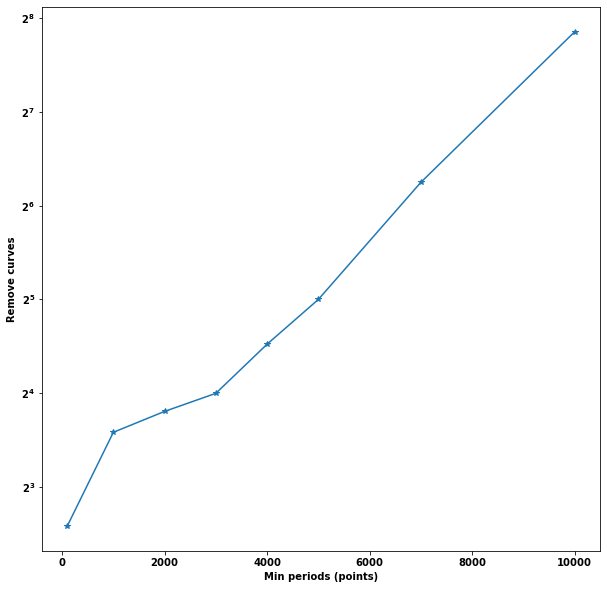

In [109]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
ax.plot([100, 1000, 2000, 3000, 4000, 5000, 7000, 10000], sorted([len(x) for x in nans] + [23]), '*-')
ax.set_yscale('log', base=2)
ax.set_xlabel('Min periods (points)')
ax.set_ylabel('Remove curves')

# for i in range(8):
#     num_points = [100, 1000, 2000, 3000, 4000, 5000, 7000, 10000][i]
#     nans_curves = sorted([len(x) for x in nans] + [23])[i]
#     ax.annotate(f"({num_points}, {nans_curves})", (num_points - 500, nans_curves + 0.75))

plt.savefig('curves_vs_points.png')
plt.savefig('curves_vs_points.pdf')

In [61]:
min_num_points_list[3],

3000

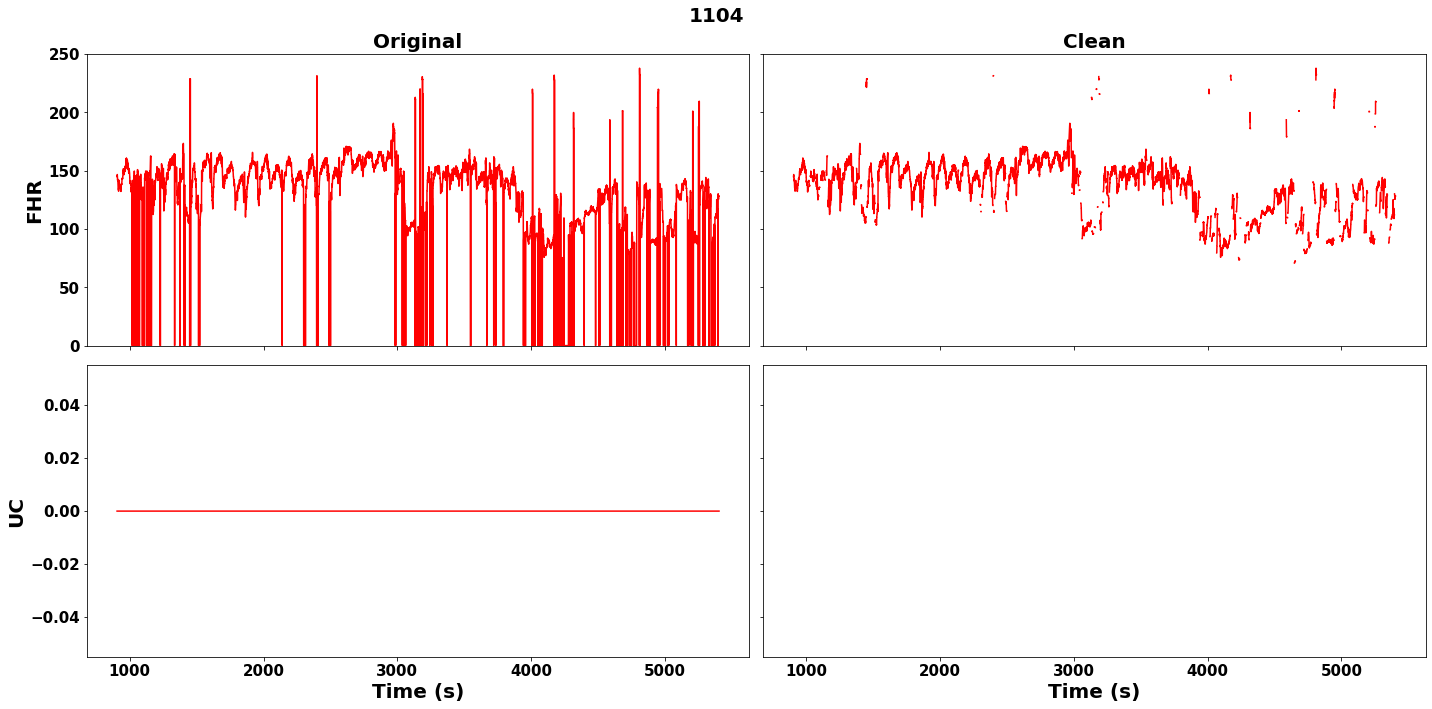

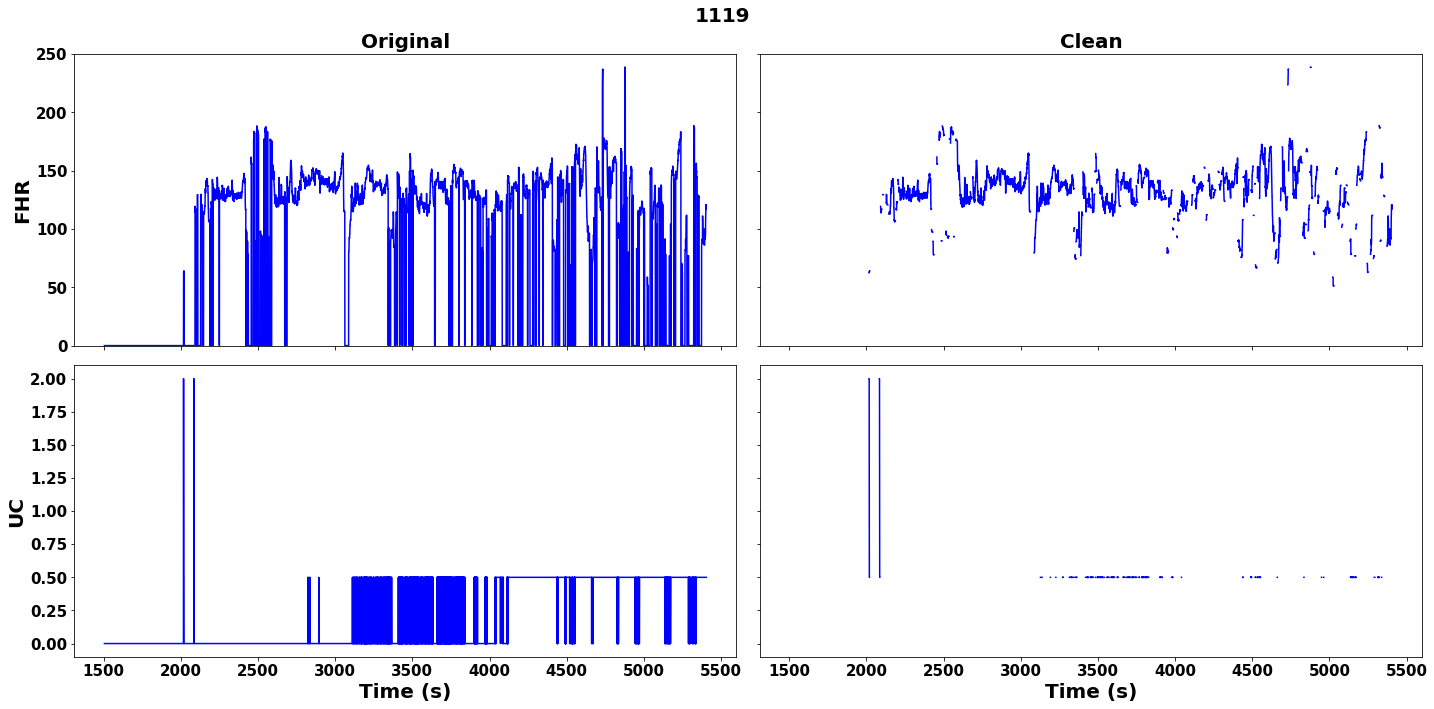

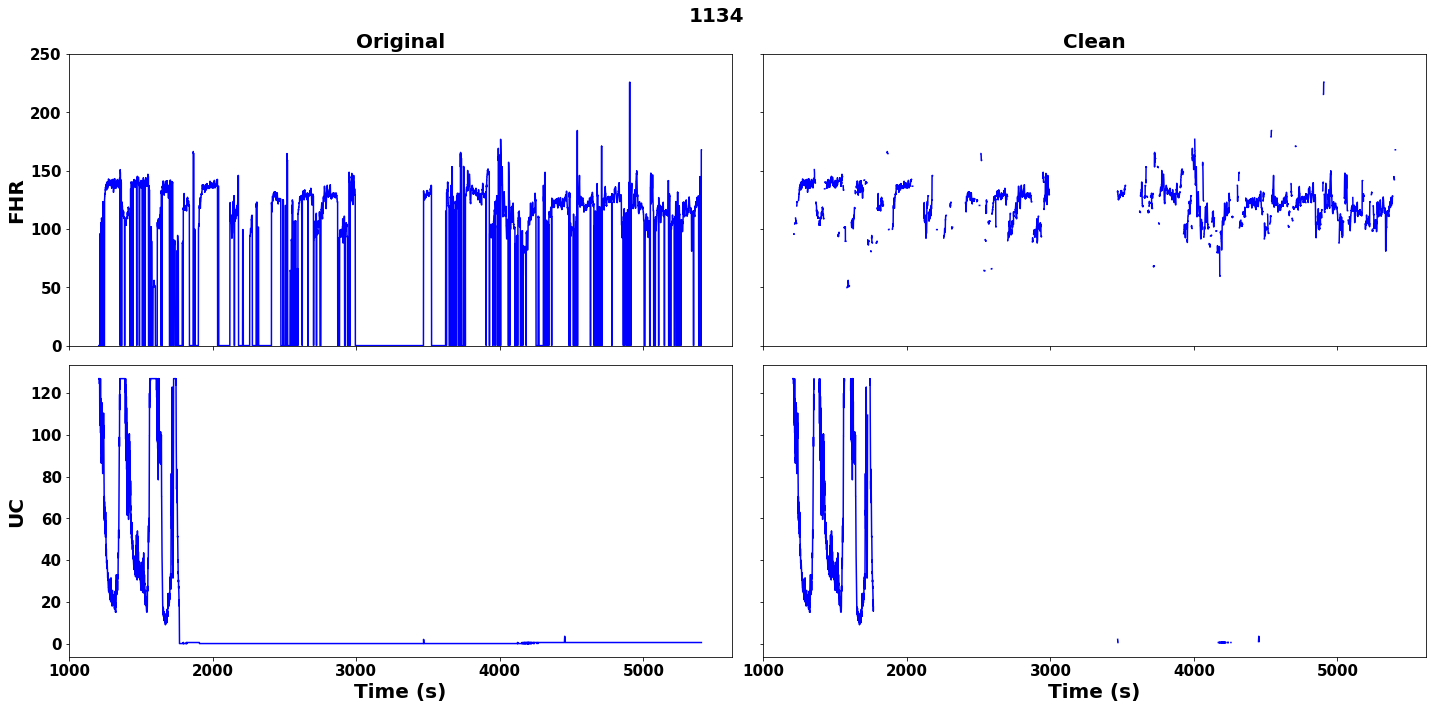

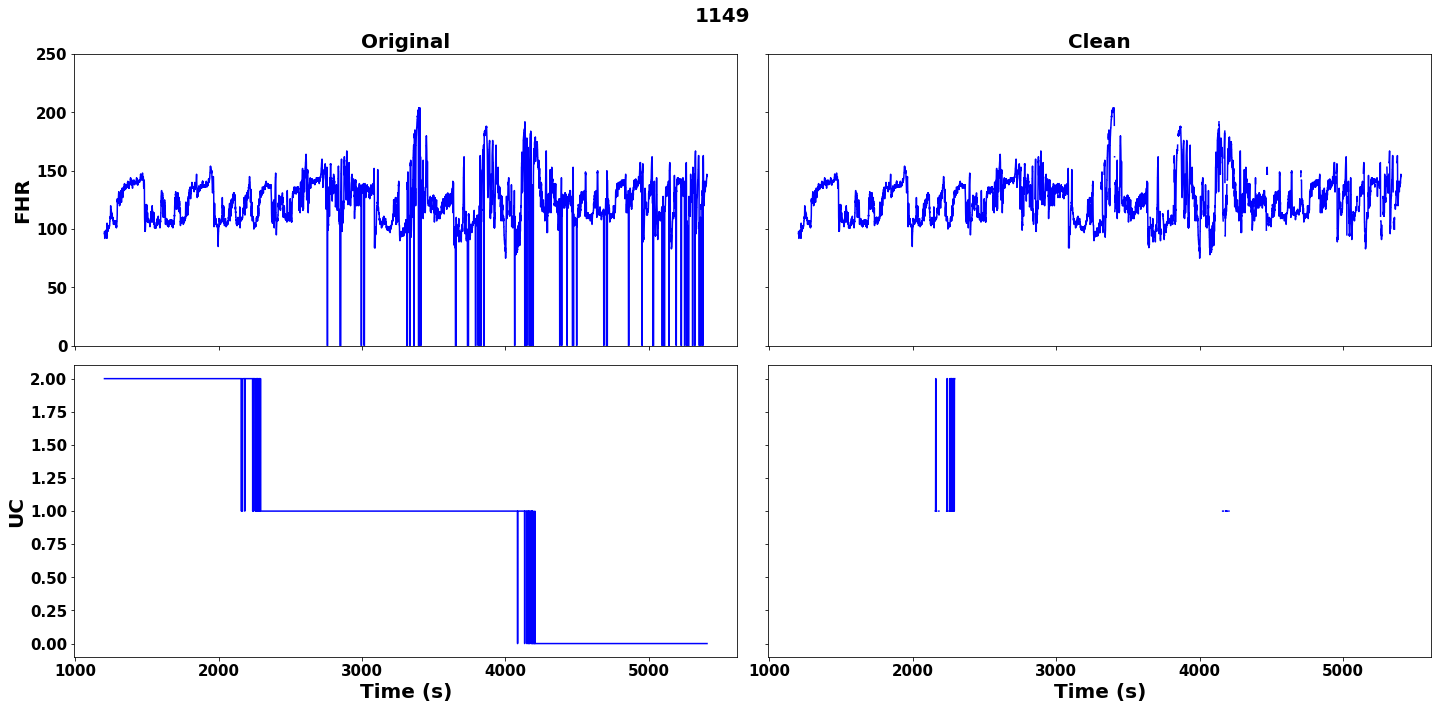

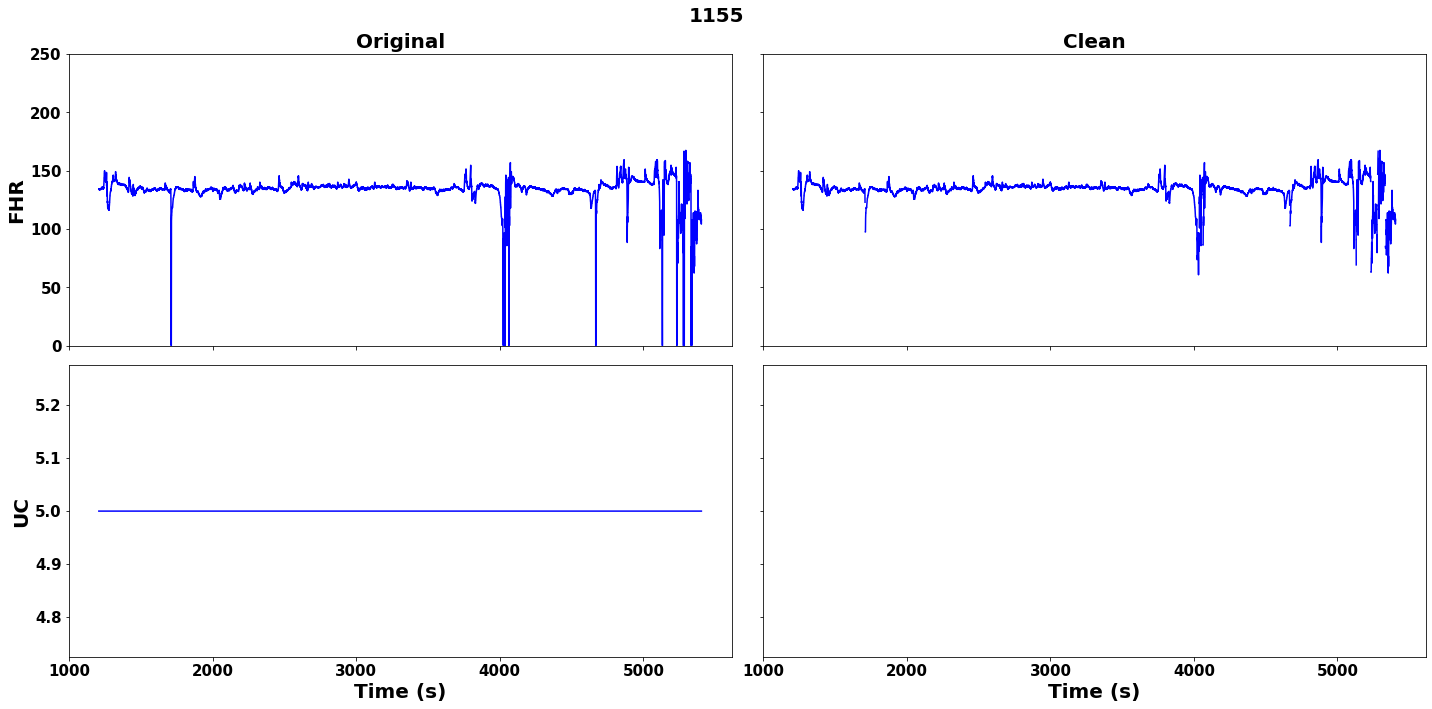

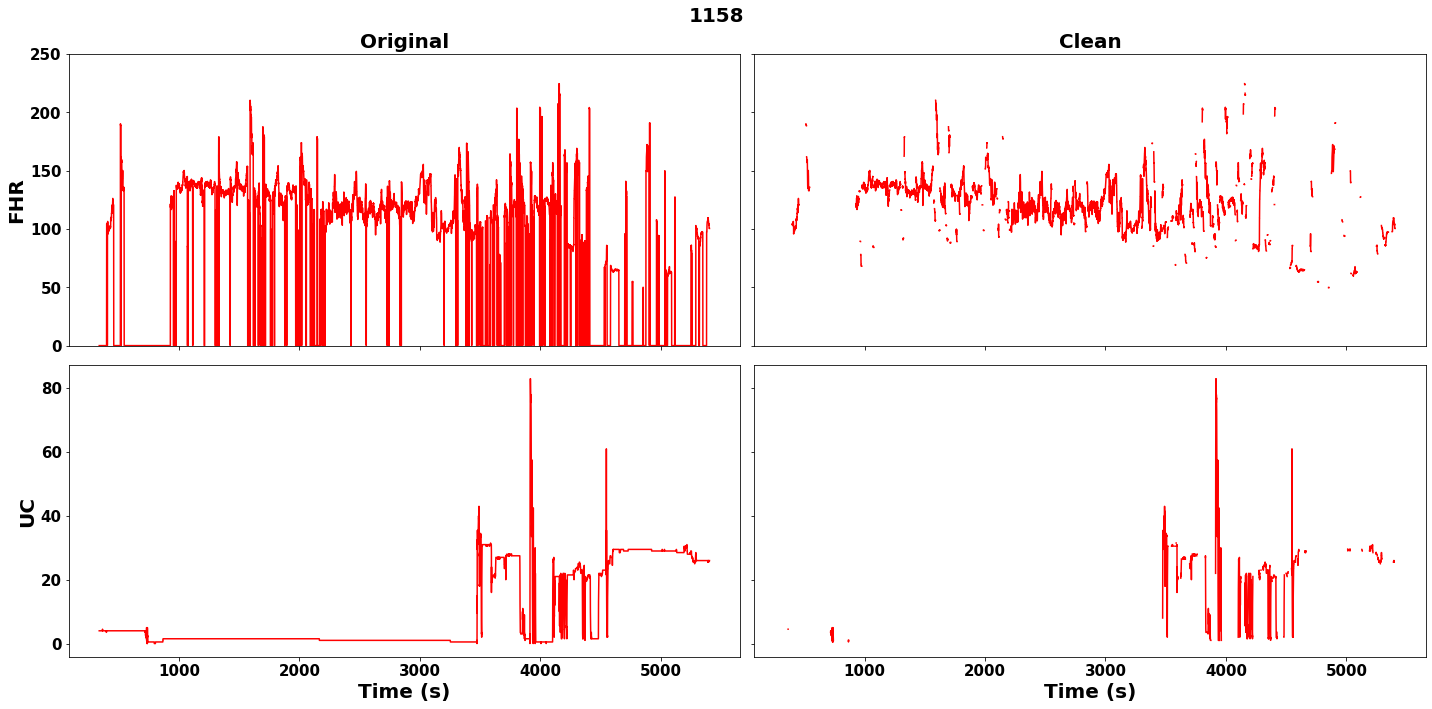

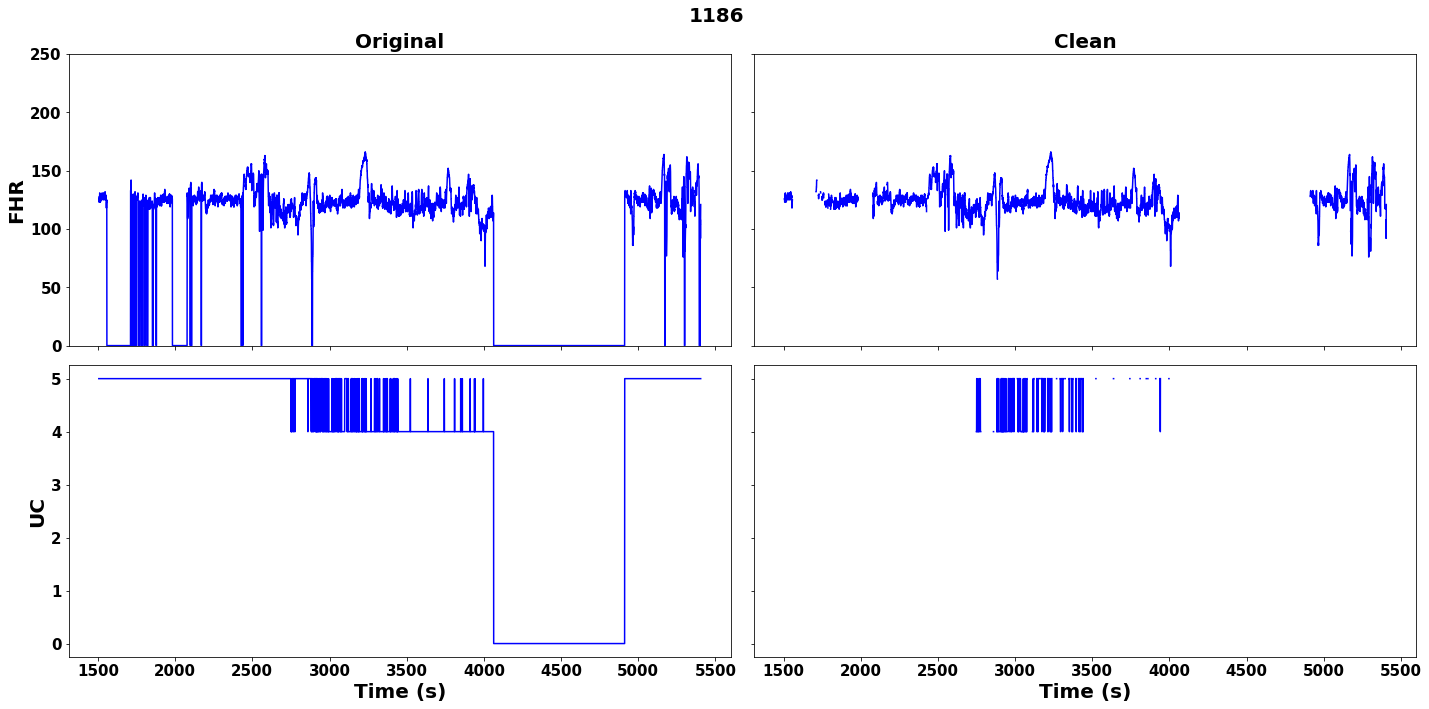

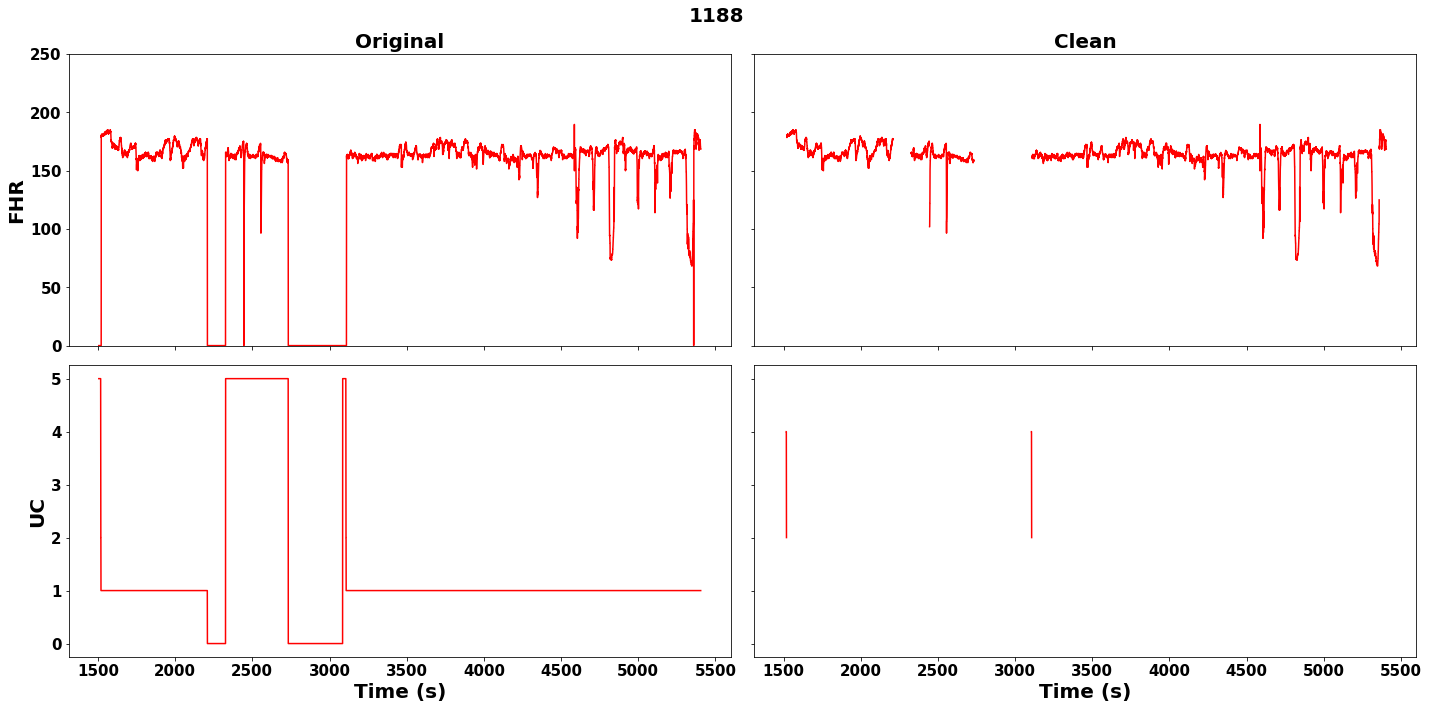

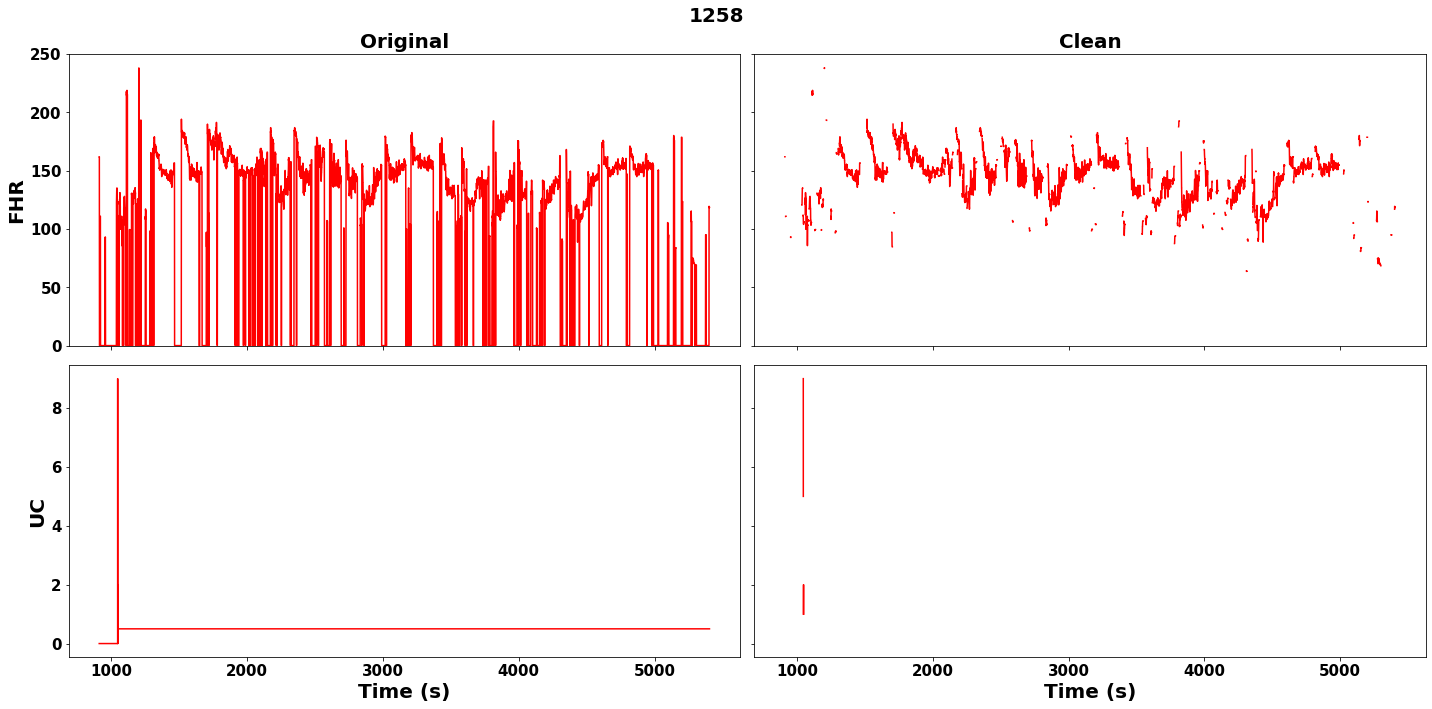

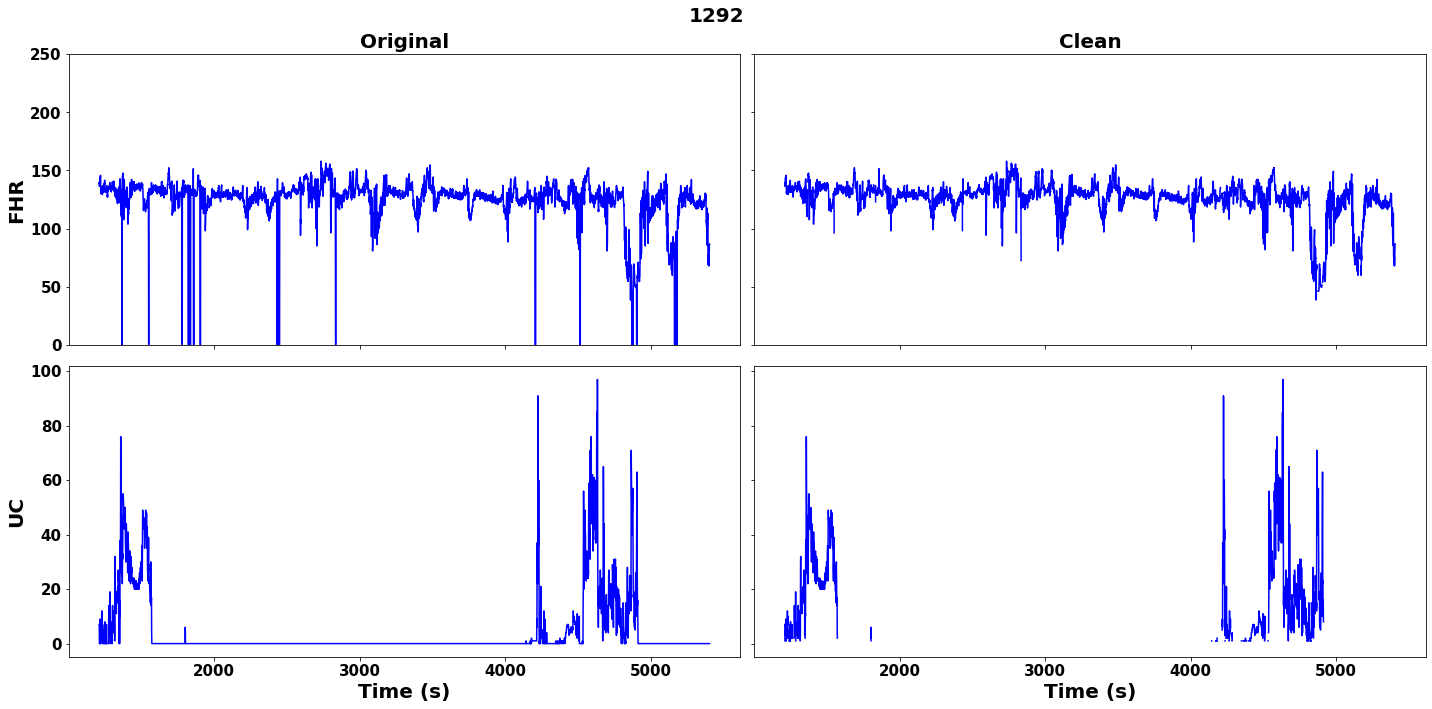

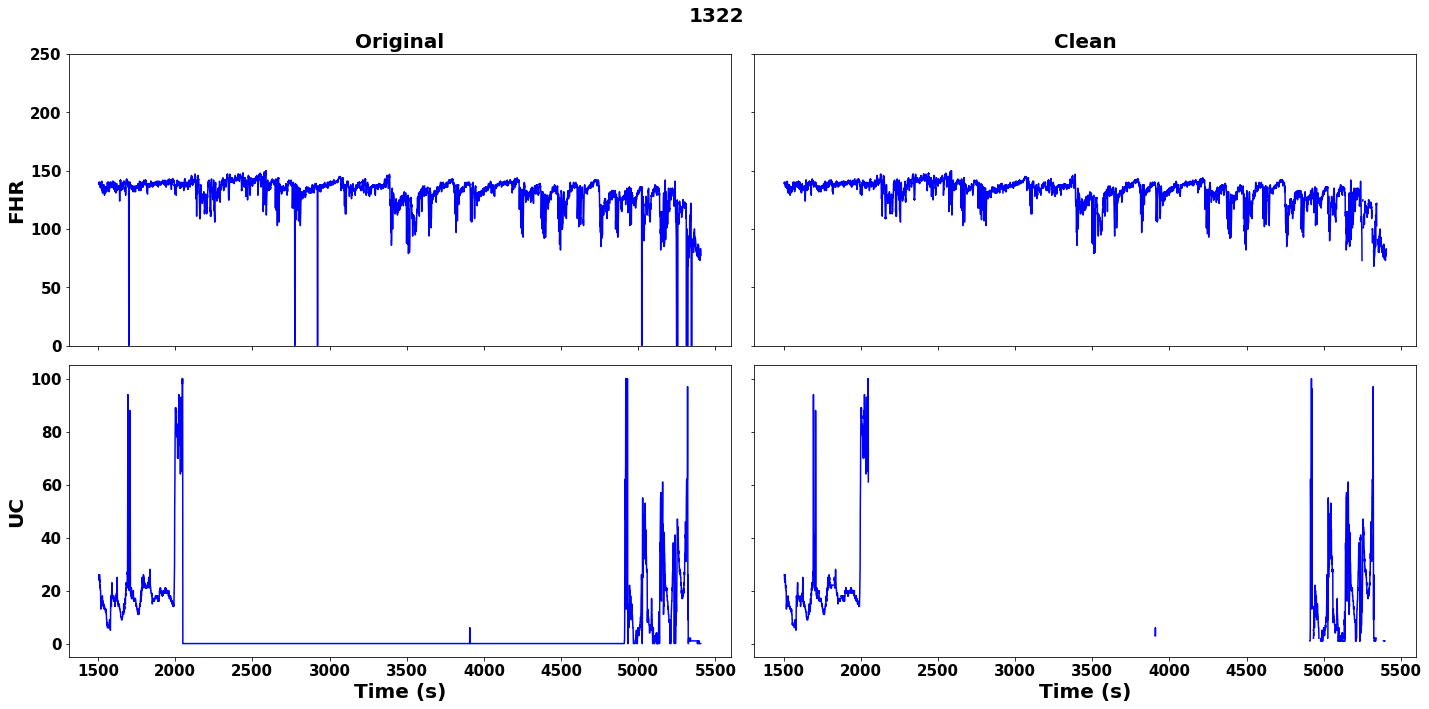

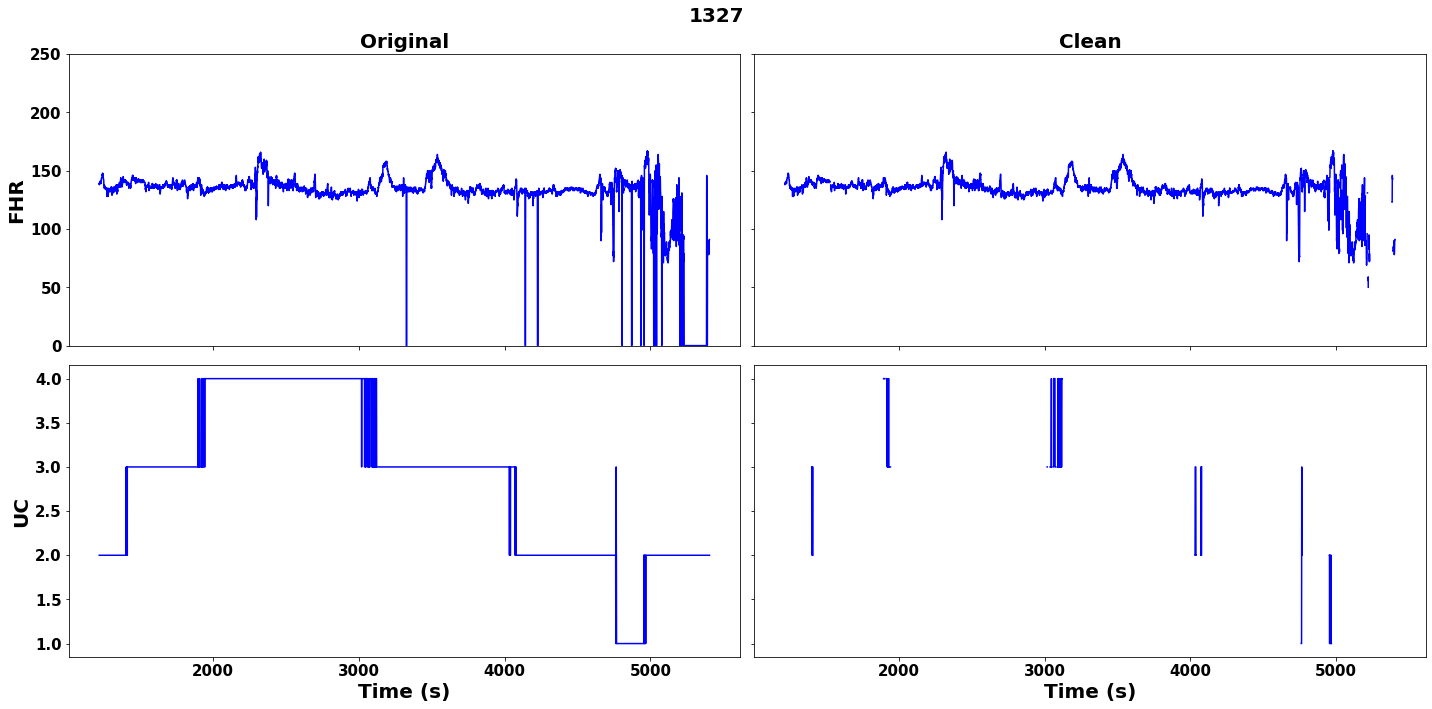

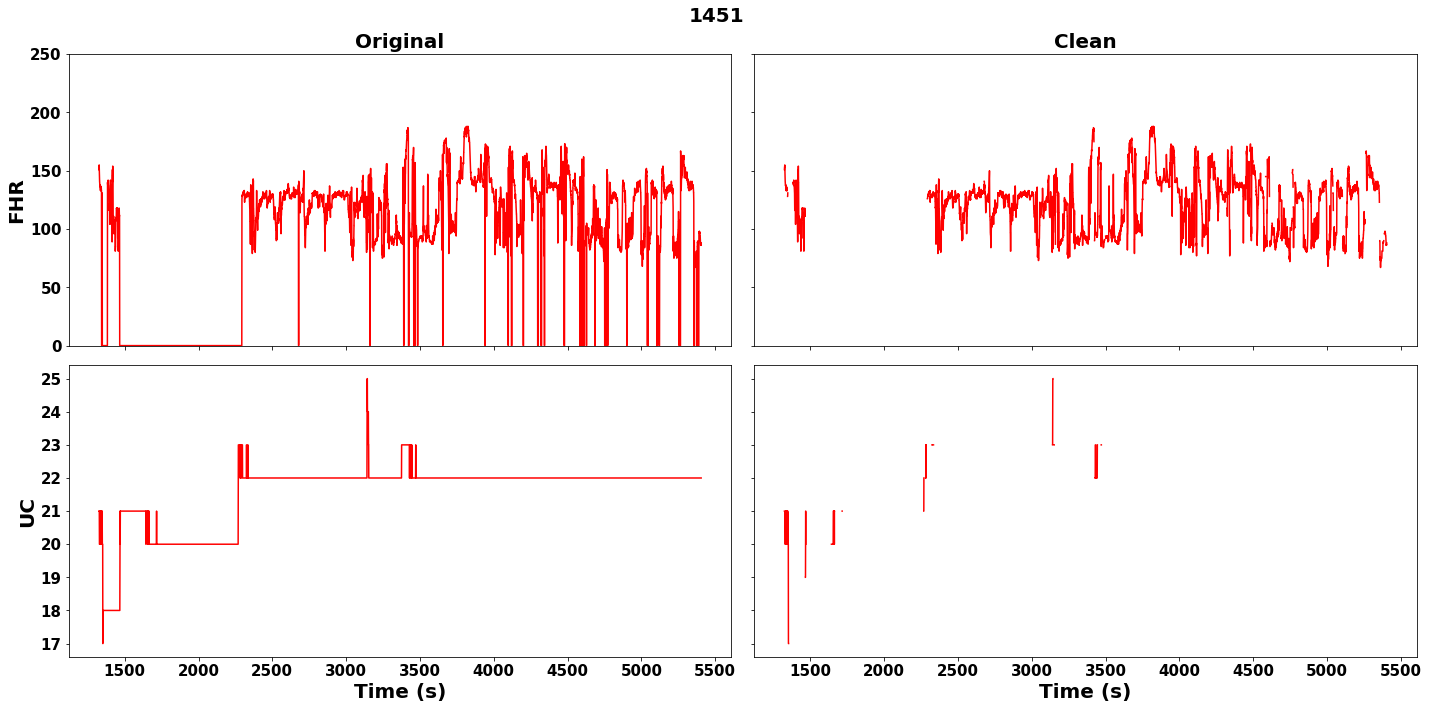

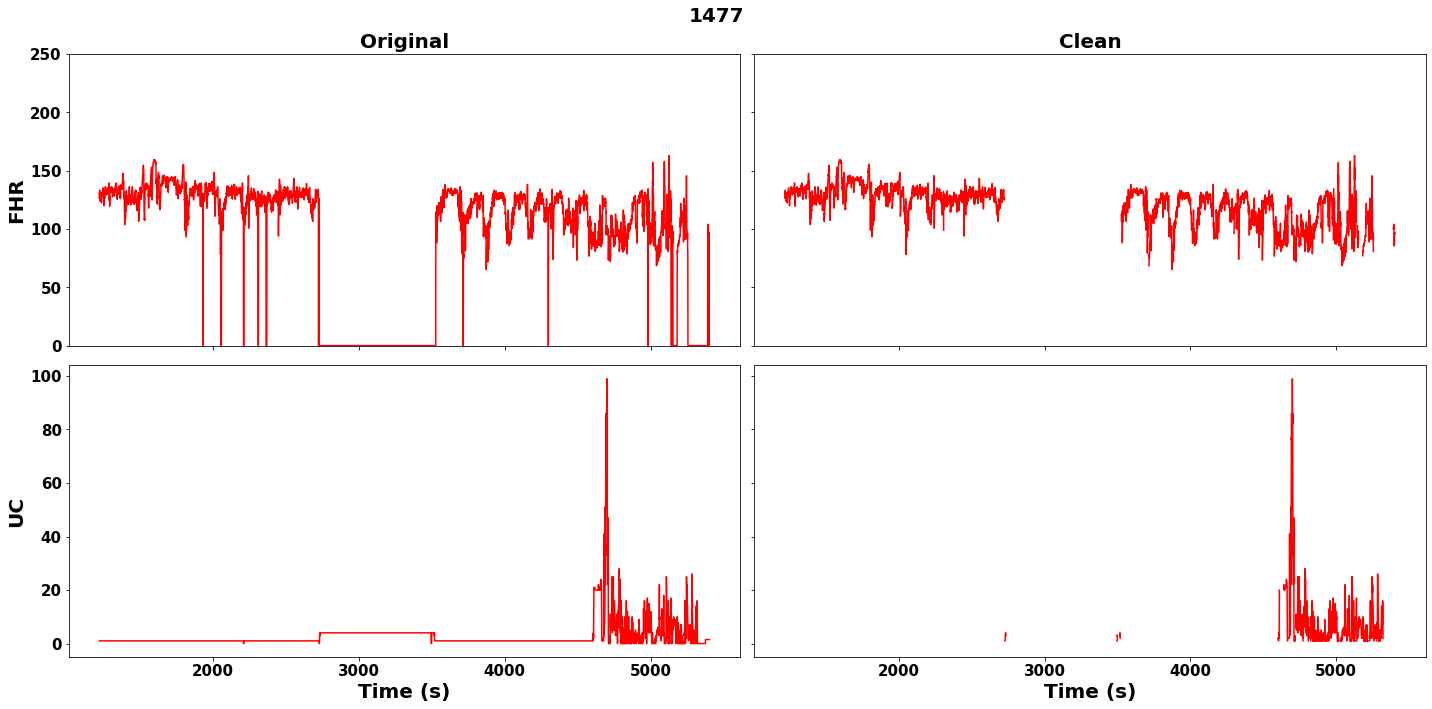

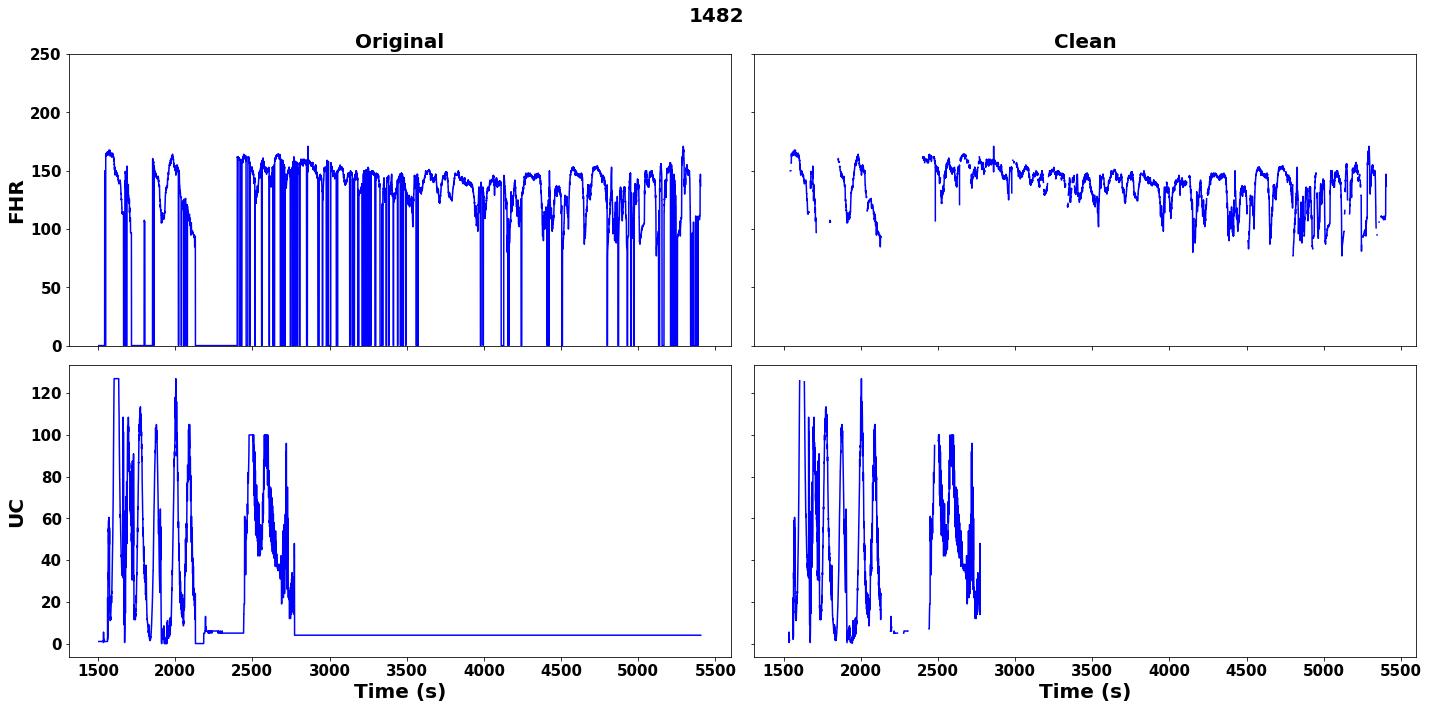

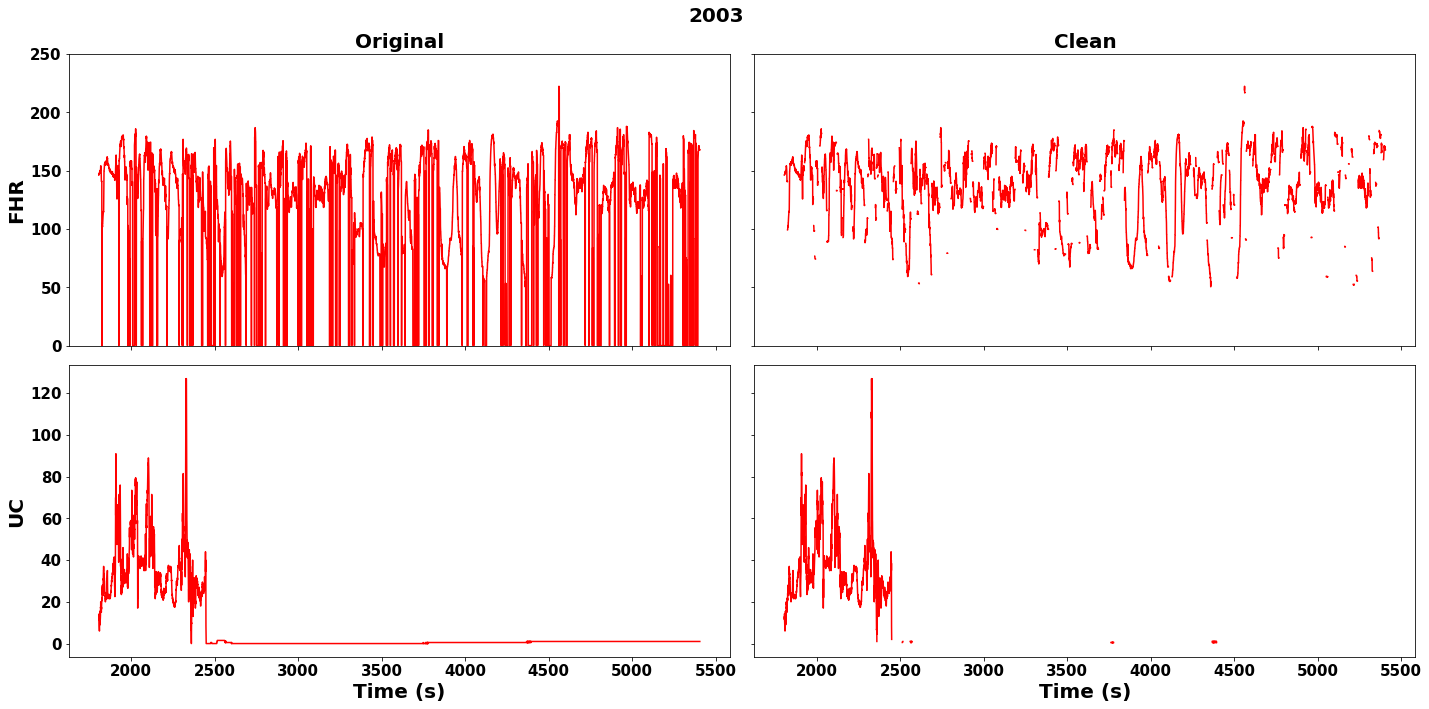

In [60]:
for idx in nans[3]:
    fig, ax = plt.subplots(nrows=2, ncols=2, sharex='all', sharey='row', figsize=(20, 10))
    color = 'red' if y[idx] == 1 else 'blue'

    ax[0, 0].plot(fhr.loc[idx].index, fhr.loc[idx].values, color=color)
    ax[0, 1].plot(fhr_clean.loc[idx].index, fhr_clean.loc[idx].values, color=color)
    for fhr_ax in ax[0]:
        fhr_ax.set_ylim((0, 250))

    ax[1, 0].plot(uc.loc[idx].index, uc.loc[idx].values, color=color)
    ax[1, 1].plot(uc_clean.loc[idx].index, uc_clean.loc[idx].values, color=color)
    for uc_ax in ax[0]:
        uc_ax.set_ylim((0, 250))

    ax[1, 0].set_xlabel('Time (s)', fontsize=20)
    ax[1, 1].set_xlabel('Time (s)', fontsize=20)
    ax[0, 0].set_ylabel('FHR', fontsize=20)
    ax[1, 0].set_ylabel('UC', fontsize=20)

    ax[0, 0].tick_params(axis='both', which='major', labelsize=15)
    ax[1, 0].tick_params(axis='both', which='major', labelsize=15)
    ax[1, 1].tick_params(axis='both', which='major', labelsize=15)

    ax[0,0].set_title('Original', fontsize=20)
    ax[0,1].set_title('Clean', fontsize=20)

    fig.suptitle(f'{idx}', fontsize=20)
    fig.tight_layout()
    plt.savefig(f"REMOVED CURVES PLOTS (NaN)/{idx}.pdf")
    plt.savefig(f"REMOVED CURVES PLOTS (NaN)/{idx}.png")
    plt.show()
